In [297]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

Use the dataset UsArrests.csv included in this folder to generate a similar in-depth PCA report of the data. Explore as much as you can, motivate the pre-processing steps you take, and interpret the outcomes of any analyses.


In [298]:
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Checking that the datatypes aren't string and that there are no null values

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Using a heat map to identify the strength of correlation between each field

C:\Users\natha\AppData\Local\Temp\ipykernel_19040\2696901964.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  arrest_corr = df.corr()


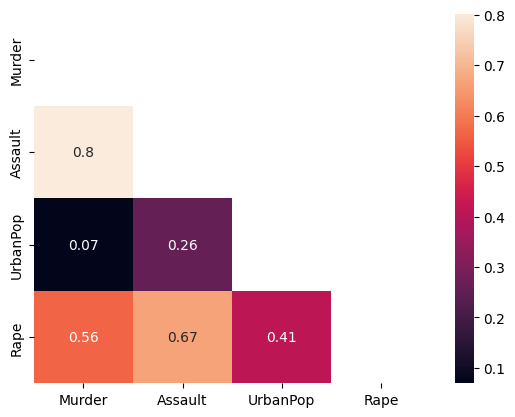

In [300]:
plt.figure()
arrest_corr = df.corr()
dropmirror = np.zeros_like(arrest_corr)
dropmirror[np.triu_indices_from(dropmirror)] = True
sns.heatmap(arrest_corr, annot=True, mask=dropmirror)
plt.show()

Using a plot to highlight the distribution of the types of arrest

Text(0.5, 1.0, 'The distribution of the types of arrest')

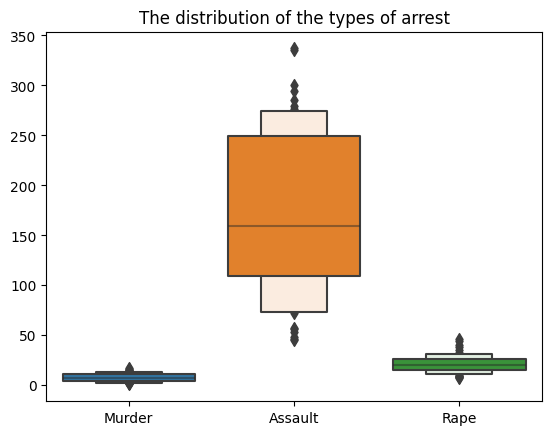

In [301]:
sns.boxenplot(data=df.drop(columns='UrbanPop'))
plt.title('The distribution of the types of arrest')

Scaling the data

In [302]:
scaled = StandardScaler().fit_transform(df.drop(columns='City'))
df_scaled = pd.DataFrame(scaled, columns=df.columns[1:5])
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


Text(1, 60.5, '60% theshold minimum')

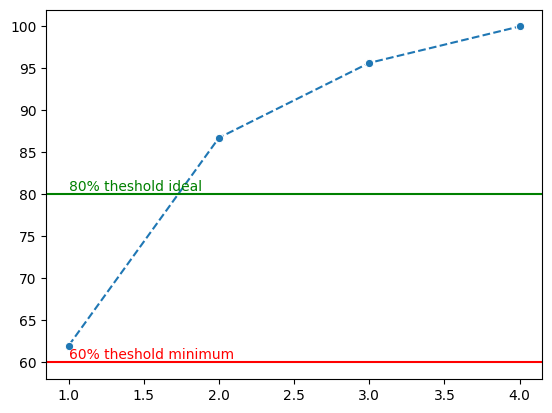

In [303]:
pca = PCA().fit(df_scaled)
sns.lineplot(x=np.arange(1,5,step=1), y=np.cumsum(pca.explained_variance_ratio_)*100, linestyle='--', marker='o')
plt.axhline(y=80, color='g', linestyle='-')
plt.text(1,80.5,'80% theshold ideal', color='green')
plt.axhline(y=60, color='r', linestyle='-')
plt.text(1,60.5,'60% theshold minimum', color='red')

Creating a dataframe with the principle components variations

In [304]:
pca = PCA(n_components = 2)
pc_df = pd.DataFrame(data=pca.fit_transform(df_scaled), columns=['Principle Component 1', 'Principle Component 2'])
pc_df['State'] = df['City']
pc_df.head()

,Principle Component 1,Principle Component 2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


Producing a biplot to represent components within the dataframe

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


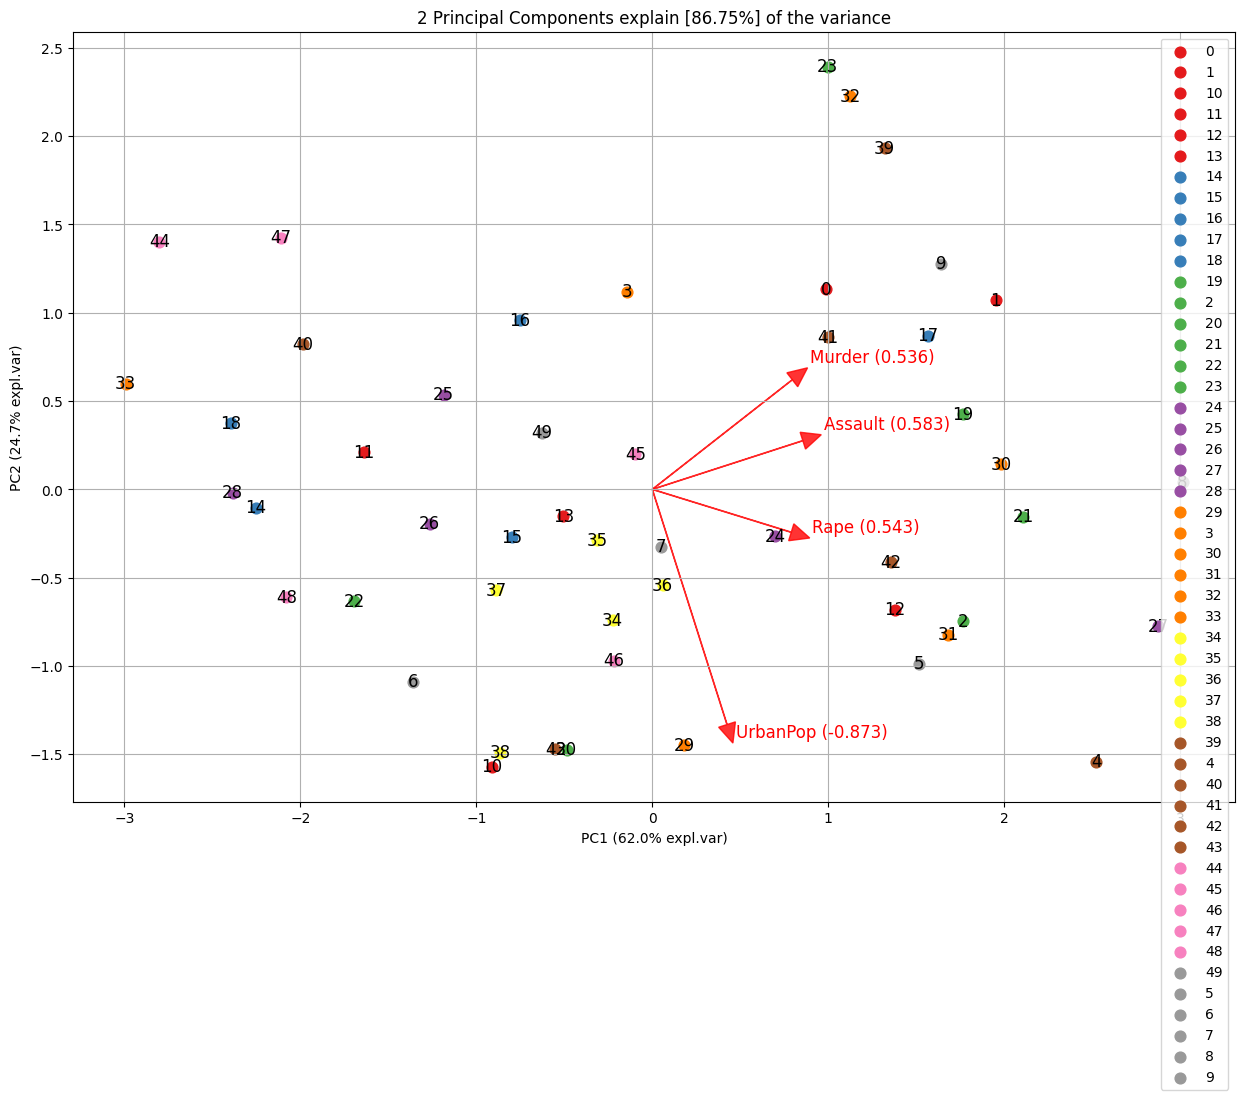

In [305]:
from pca import pca
model = pca(n_components=2)
results = model.fit_transform(df_scaled)
fig, ax = model.biplot(n_feat=4)

You are also required to do an application of two clustering techniques and an analysis of the clusters they generate. Try and see if you can find anything common within each cluster that has been found.


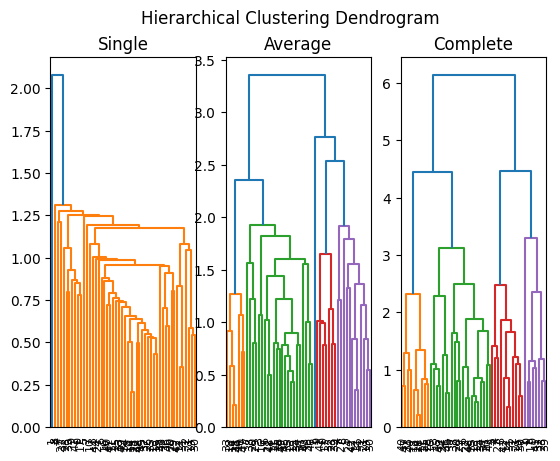

In [306]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_scaled)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(df_scaled, method='single'), labels=df_scaled.index, ax=ax1)
ax2.set_title("Average")
dendrogram(linkage(df_scaled, method='average'), labels=df_scaled.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(df_scaled, method='complete'), labels=df_scaled.index, ax=ax3)
plt.show()

Using Hierarchical Clustering as it will determine the number of clusters, we can see that the most balanced dispersion is produced using complete linkage and has produced 4 clusters

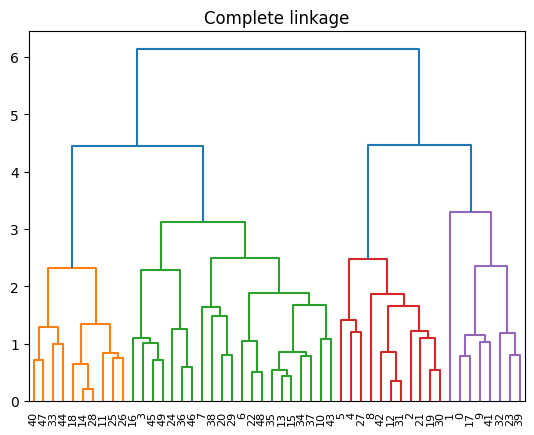

In [307]:
plt.title("Complete linkage")
dendrogram(linkage(df_scaled, method='complete'), labels=df_scaled.index)
plt.show()

When using Kmeans it is best to use the features that have a higher significance

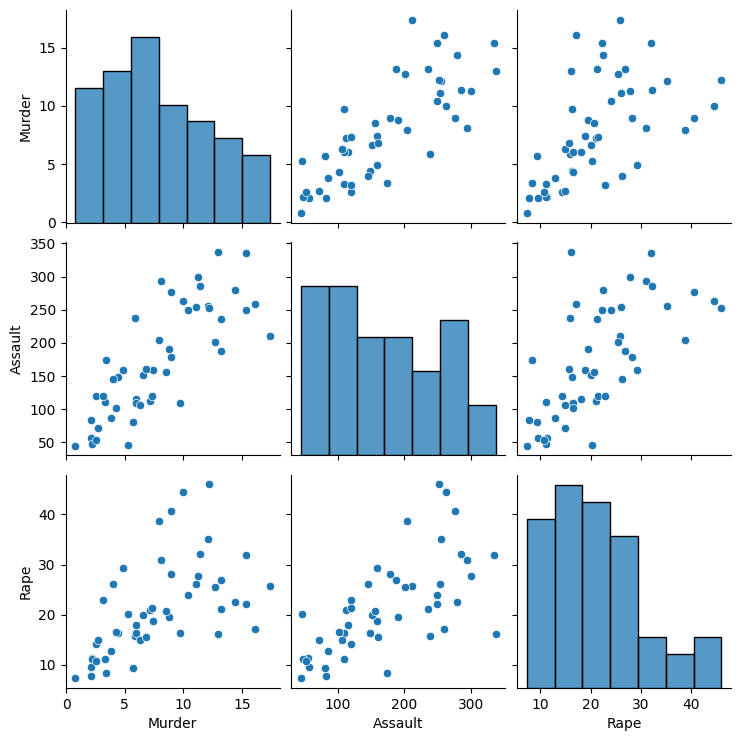

In [308]:
df_arrests=df.drop(columns={'City', 'UrbanPop'})
sns.pairplot(df_arrests)

We can see that murder and assault have a closer correlation and appear to be clustered so I will continue with these.
Since we need to supply a number of clusters for Kmeans I will evaluate the data with the elbow technique

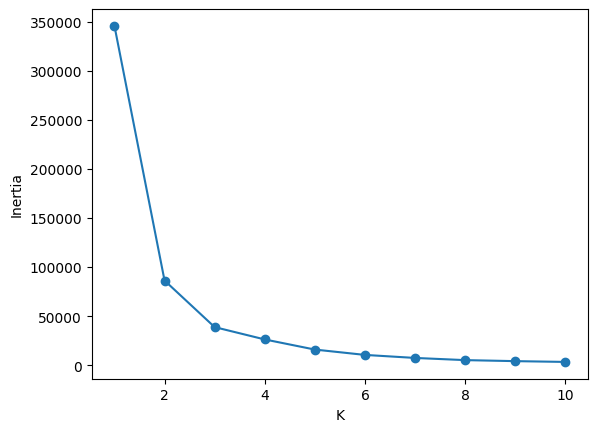

In [309]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()


elbow_Kmeans(df_arrests)

we can see that there is 1 point that stands out as having the smallest angle that being when we have 2 clusters

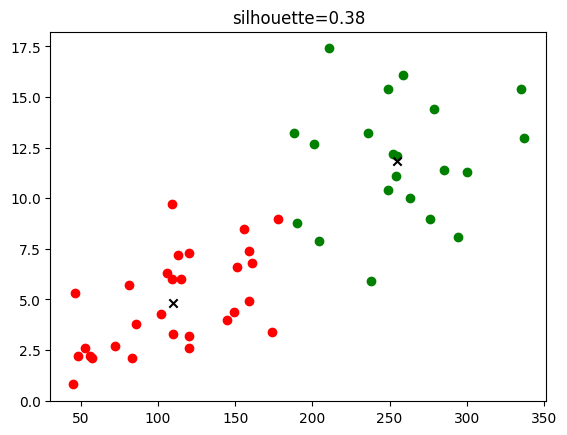

In [310]:
def scatter_Kmeans(x, k):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++')
    y_pred = kmeans.fit_predict(x)
    colours = 'rgb'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(df_scaled, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score))
    plt.show()

x = df[['Assault', 'Murder']].values.reshape(-1,2)  
scatter_Kmeans(x, 2)

Push all the work that you have generated for this project to GitHub.